# Houses and Empty Lots for Sale in New Brunswick (as of June 12, 2020)

In this project, I scraped data from this [website](https://www.point2homes.com/CA/Real-Estate-Listings/NB.html) which lists houses and 
empty lots for sale. The selling price is listed along with the lot size. For houses, the number of bedrooms, bathrooms, the house size the house type are also given.

## 1.1 The Training Set


In [1]:
# load libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import re
from tqdm.notebook import tqdm

train = pd.read_csv('train.csv')
val = pd.read_csv('val.csv')

# look at first 5 rows of training set
train.head(5)

,Address,Beds,Baths,House Size (sqft),Lot Size (ac),Type,Postal Code,Price
0,"Haute Aboujagane Land, Haute Aboujagane, New B...",NaN,NaN,NaN,NaN,Residential,E4P5M8,43000
1,"121-127 Wright Street, Indiantown, New Brunswick",NaN,NaN,10000.0,NaN,Family,E2K3Z5,899900
2,"2852 Route 117, Kouchibouguac, New Brunswick",NaN,NaN,NaN,1.02,Residential,E4X2P2,75000
3,"Lot Route 955, Murray Corner, New Brunswick, E...",NaN,NaN,NaN,NaN,Empty Land,E4M3M2,99000
4,"298 French Lake Road, French Lake, New Brunswick",3.0,2.0,1245.0,NaN,Family,E2V4E2,94900


In [2]:
# get summary statistics
train.describe()

,Beds,Baths,House Size (sqft),Lot Size (ac),Price
count,374.000000,369.00000,265.000000,180.000000,5.370000e+02
mean,3.278075,1.97019,1918.037736,15.348144,1.949296e+05
std,1.133313,0.89484,1174.246637,86.120217,1.731198e+05
min,1.000000,1.00000,256.000000,0.019000,8.000000e+03
25%,3.000000,1.00000,1176.000000,0.309500,7.990000e+04
50%,3.000000,2.00000,1566.000000,1.000000,1.499000e+05
75%,4.000000,2.00000,2300.000000,2.767500,2.599000e+05
max,10.000000,5.00000,10000.000000,869.000000,1.530000e+06


In [3]:
# get unique postal codes
len(train['Postal Code'].unique())

487

There are a lot of postal codes. To reduce the variability of postal codes, we just get the first half of the postal code.

In [4]:
train['Postal'] = train['Postal Code'].str[:3]
train.head(5)

,Address,Beds,Baths,House Size (sqft),Lot Size (ac),Type,Postal Code,Price,Postal
0,"Haute Aboujagane Land, Haute Aboujagane, New B...",NaN,NaN,NaN,NaN,Residential,E4P5M8,43000,E4P
1,"121-127 Wright Street, Indiantown, New Brunswick",NaN,NaN,10000.0,NaN,Family,E2K3Z5,899900,E2K
2,"2852 Route 117, Kouchibouguac, New Brunswick",NaN,NaN,NaN,1.02,Residential,E4X2P2,75000,E4X
3,"Lot Route 955, Murray Corner, New Brunswick, E...",NaN,NaN,NaN,NaN,Empty Land,E4M3M2,99000,E4M
4,"298 French Lake Road, French Lake, New Brunswick",3.0,2.0,1245.0,NaN,Family,E2V4E2,94900,E2V


In [5]:
# get number if unique 'Postal'
len(train.Postal.unique())

88

Ninety is not that bad. Now we check the histogram of **Postal**.

/Users/renzoflores/anaconda3/lib/python3.7/site-packages/plotnine/stats/stat_bin.py:93: PlotnineWarning: 'stat_bin()' using 'bins = 10'. Pick better value with 'binwidth'.


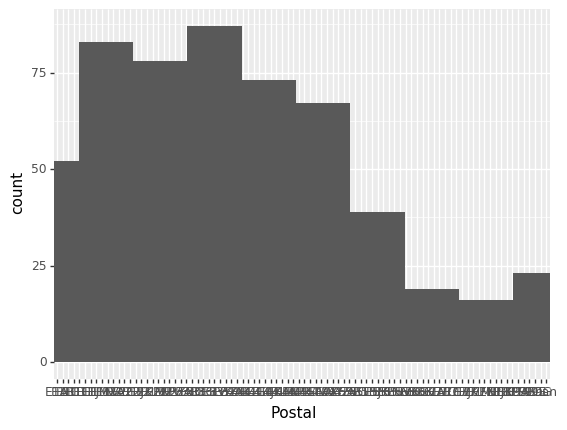

<ggplot: (7010128453)>

In [6]:
from plotnine import *

ggplot(train, aes(x='Postal')) + geom_histogram()

In [7]:
# get minimum counts for postal
train.Postal.value_counts()

E3L    57
E1A    30
E5B    27
E3A    25
E4P    24
       ..
E7P     1
E7N     1
E7G     1
E2Z     1
E7L     1
Name: Postal, Length: 87, dtype: int64

Okay, so there are plenty of postal codes with only ones in them. So we just pick the first two characters of the postal code instead.

In [8]:
train['Postal'] = train['Postal'].str[:-1]
train.Postal.value_counts()

E3    121
E4    115
E1    110
E5     72
E2     61
E9     18
E7     14
E6     13
E8      8
Name: Postal, dtype: int64

Much better. We can now drop the postal code.

In [9]:
train.drop('Postal Code',axis=1,inplace=True)
train.head(5)

,Address,Beds,Baths,House Size (sqft),Lot Size (ac),Type,Price,Postal
0,"Haute Aboujagane Land, Haute Aboujagane, New B...",NaN,NaN,NaN,NaN,Residential,43000,E4
1,"121-127 Wright Street, Indiantown, New Brunswick",NaN,NaN,10000.0,NaN,Family,899900,E2
2,"2852 Route 117, Kouchibouguac, New Brunswick",NaN,NaN,NaN,1.02,Residential,75000,E4
3,"Lot Route 955, Murray Corner, New Brunswick, E...",NaN,NaN,NaN,NaN,Empty Land,99000,E4
4,"298 French Lake Road, French Lake, New Brunswick",3.0,2.0,1245.0,NaN,Family,94900,E2


/Users/renzoflores/anaconda3/lib/python3.7/site-packages/plotnine/stats/stat_bin.py:93: PlotnineWarning: 'stat_bin()' using 'bins = 19'. Pick better value with 'binwidth'.


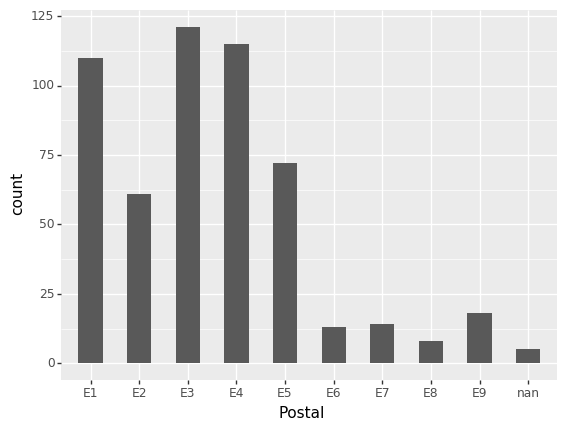

<ggplot: (7012267945)>

In [10]:
# check histogram for Postal
ggplot(train, aes(x='Postal')) + geom_histogram()

In [11]:
# there is a null value. let's check the address(es)
train[train.Postal.isnull()]

,Address,Beds,Baths,House Size (sqft),Lot Size (ac),Type,Price,Postal
25,"Lot Route 390, Greater Perth - Andover, New Br...",NaN,NaN,NaN,NaN,Empty Land,80000,NaN
146,"2100 Bridletowne Cir, Clarks Corners, New Brun...",3.0,2.0,1390.0,NaN,Residential,820000,NaN
179,"20 Burlington Court, Pokiok, New Brunswick",NaN,NaN,NaN,NaN,Empty Land,124000,NaN
389,"Woodlot on Route 118, Miramichi, New Brunswick",NaN,NaN,NaN,NaN,Empty Land,39900,NaN
451,"71 Pointe des Robichaud, Val - Comeau, New Bru...",3.0,1.0,NaN,NaN,Family,319000,NaN


According to Wikipedia and some searching in Google, Greater Perth-Andover has postal codes starting with E7. As for Miramichi and Val-Comeau, it starts with E1. For Pokiok, its E6 and for Clarks Corner its E4.

In [12]:
nan_postal = {25 : 'E7', 389: 'E1', 451: 'E1', 179: 'E6', 146: 'E4'}

for index, post in nan_postal.items():
    train.loc[index,'Postal'] = post

train.loc[nan_postal.keys(),:]

,Address,Beds,Baths,House Size (sqft),Lot Size (ac),Type,Price,Postal
25,"Lot Route 390, Greater Perth - Andover, New Br...",NaN,NaN,NaN,NaN,Empty Land,80000,E7
389,"Woodlot on Route 118, Miramichi, New Brunswick",NaN,NaN,NaN,NaN,Empty Land,39900,E1
451,"71 Pointe des Robichaud, Val - Comeau, New Bru...",3.0,1.0,NaN,NaN,Family,319000,E1
179,"20 Burlington Court, Pokiok, New Brunswick",NaN,NaN,NaN,NaN,Empty Land,124000,E6
146,"2100 Bridletowne Cir, Clarks Corners, New Brun...",3.0,2.0,1390.0,NaN,Residential,820000,E4


We can also drop the addresses now since we have the postal codes. 

In [13]:
train.drop('Address',axis=1, inplace=True)

In [14]:
train.head(5)

,Beds,Baths,House Size (sqft),Lot Size (ac),Type,Price,Postal
0,NaN,NaN,NaN,NaN,Residential,43000,E4
1,NaN,NaN,10000.0,NaN,Family,899900,E2
2,NaN,NaN,NaN,1.02,Residential,75000,E4
3,NaN,NaN,NaN,NaN,Empty Land,99000,E4
4,3.0,2.0,1245.0,NaN,Family,94900,E2


We now look at the distributions of beds and baths.

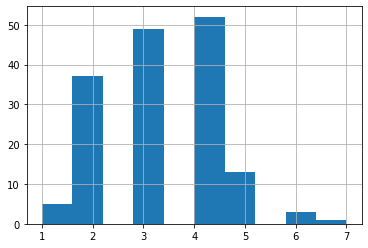

In [15]:
train[train['Type']=='Residential']['Beds'].hist()

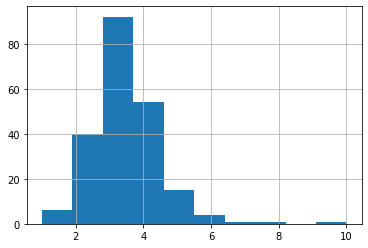

In [16]:
train[train['Type']=='Family']['Beds'].hist()

The distribution is slightly skewed to the right for both types, indicating that most houses typically have ~3 beds. Now, if the type is Empty Land, obviously there are no beds, so we set Beds = 0, and we impute the beds with the median number. We also add a column indicating missingness of beds.

In [17]:
# check the median
beds_resid_impute = train[train['Type']=='Residential']['Beds'].median(skipna=True)
print(beds_resid_impute)
beds_fam_impute = train[train['Type']=='Family']['Beds'].median(skipna=True)
print(beds_fam_impute)

3.0
3.0


In [19]:
# for residential and family houses, the median number of beds are essentially the same.
# now I'm thinking of just joining Residential and Family.

train = train.replace('Family','Residential')
train['Type'].unique()

array(['Residential', 'Empty Land'], dtype=object)

In [21]:
train['Missing Beds'] = 0
train.head(5)

for ind, typ in tqdm(train['Type'].items(), total = len(train['Type'])):
    if typ == 'Empty Land':
        train.loc[ind,'Beds'] = 0
    elif np.isnan(train.loc[ind,'Beds']):
        train.loc[ind,'Beds'] = beds_fam_impute
        train.loc[ind,'Missing Beds'] = 1

train.head(5)

,Beds,Baths,House Size (sqft),Lot Size (ac),Type,Price,Postal,Missing Beds
0,3.0,NaN,NaN,NaN,Residential,43000,E4,1
1,3.0,NaN,10000.0,NaN,Residential,899900,E2,1
2,3.0,NaN,NaN,1.02,Residential,75000,E4,1
3,0.0,NaN,NaN,NaN,Empty Land,99000,E4,0
4,3.0,2.0,1245.0,NaN,Residential,94900,E2,0


We do the same thing for baths.

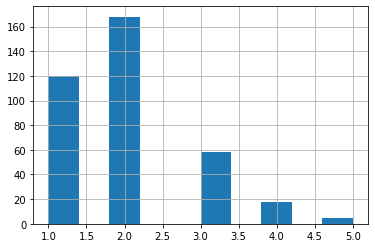

In [22]:
train['Baths'].hist()

In [23]:
baths_impute = train['Baths'].median(skipna=True)
train['Missing Baths'] = 0

for ind, typ in tqdm(train['Type'].items(), total = len(train['Type'])):
    if typ == 'Empty Land':
        train.loc[ind,'Baths'] = 0
    elif np.isnan(train.loc[ind,'Baths']):
        train.loc[ind,'Baths'] = baths_impute
        train.loc[ind,'Missing Baths'] = 1

train.head(5)

,Beds,Baths,House Size (sqft),Lot Size (ac),Type,Price,Postal,Missing Beds,Missing Baths
0,3.0,2.0,NaN,NaN,Residential,43000,E4,1,1
1,3.0,2.0,10000.0,NaN,Residential,899900,E2,1,1
2,3.0,2.0,NaN,1.02,Residential,75000,E4,1,1
3,0.0,0.0,NaN,NaN,Empty Land,99000,E4,0,0
4,3.0,2.0,1245.0,NaN,Residential,94900,E2,0,0


Perhaps if we combine the number of bedrooms and the number of bathrooms into rooms it could probably help with the learning algorithm, and so we create one.

In [24]:
train['Rooms'] = train['Beds'] + train['Baths']
train.head(5)

,Beds,Baths,House Size (sqft),Lot Size (ac),Type,Price,Postal,Missing Beds,Missing Baths,Rooms
0,3.0,2.0,NaN,NaN,Residential,43000,E4,1,1,5.0
1,3.0,2.0,10000.0,NaN,Residential,899900,E2,1,1,5.0
2,3.0,2.0,NaN,1.02,Residential,75000,E4,1,1,5.0
3,0.0,0.0,NaN,NaN,Empty Land,99000,E4,0,0,0.0
4,3.0,2.0,1245.0,NaN,Residential,94900,E2,0,0,5.0


Now we check the house size and lot size.

/Users/renzoflores/anaconda3/lib/python3.7/site-packages/plotnine/layer.py:369: PlotnineWarning: stat_density : Removed 139 rows containing non-finite values.


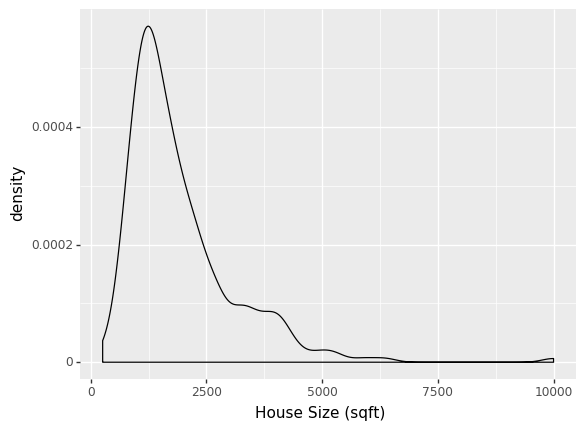

<ggplot: (7012525293)>

In [25]:
df = train[train['Type'] == 'Residential']
ggplot(df, aes(x='House Size (sqft)')) + geom_density()

/Users/renzoflores/anaconda3/lib/python3.7/site-packages/plotnine/layer.py:369: PlotnineWarning: stat_density : Removed 76 rows containing non-finite values.


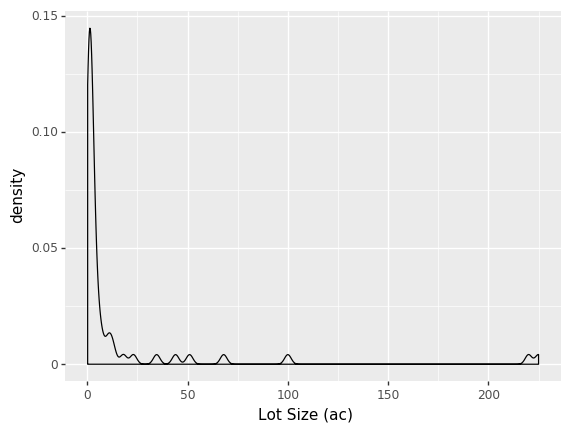

<ggplot: (7012544981)>

In [26]:
df = train[train['Type'] == 'Empty Land']
ggplot(df, aes(x='Lot Size (ac)')) + geom_density()

/Users/renzoflores/anaconda3/lib/python3.7/site-packages/plotnine/layer.py:369: PlotnineWarning: stat_density : Removed 281 rows containing non-finite values.


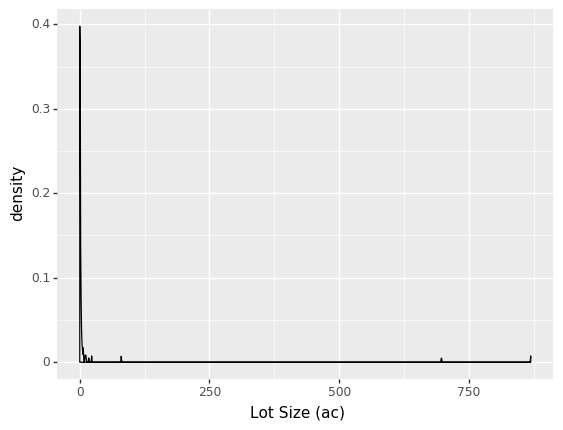

<ggplot: (7012544873)>

In [27]:
df = train[train['Type'] == 'Residential']
ggplot(df, aes(x='Lot Size (ac)')) + geom_density()

Once again, all distributions are skewed to the right, so we impute with their median.

In [28]:
train['Missing House'] = 0
train['Missing Land'] = 0

for ind, typ in tqdm(train['Type'].items(), total=len(train['Type'])):
    if typ == 'Empty Land':
        train.loc[ind,'House Size (sqft)'] = 0
        
        if np.isnan(train.loc[ind,'Lot Size (ac)']):
            train.loc[ind,'Lot Size (ac)'] = train[train['Type'] == typ]['Lot Size (ac)'].median(skipna=True)
            train.loc[ind,'Missing Land'] = 1
            
    elif typ == 'Residential':
        
        if np.isnan(train.loc[ind,'House Size (sqft)']):
            train.loc[ind, 'House Size (sqft)'] = train[train['Type'] == typ]['House Size (sqft)'].median(skipna=True)
            train.loc[ind, 'Missing House'] = 1
        
        if np.isnan(train.loc[ind,'Lot Size (ac)']):
            train.loc[ind,'Lot Size (ac)'] = train[train['Type'] == typ]['Lot Size (ac)'].median(skipna=True)
            train.loc[ind, 'Missing Land'] = 1

In [29]:
train.head(5)

,Beds,Baths,House Size (sqft),Lot Size (ac),Type,Price,Postal,Missing Beds,Missing Baths,Rooms,Missing House,Missing Land
0,3.0,2.0,1575.0,0.68,Residential,43000,E4,1,1,5.0,1,1
1,3.0,2.0,10000.0,0.68,Residential,899900,E2,1,1,5.0,0,1
2,3.0,2.0,1575.0,1.02,Residential,75000,E4,1,1,5.0,1,0
3,0.0,0.0,0.0,1.80,Empty Land,99000,E4,0,0,0.0,0,1
4,3.0,2.0,1245.0,0.68,Residential,94900,E2,0,0,5.0,0,1


In [30]:
# save file
train.to_csv('train_cleaned.csv',index=False)